This is a document demonstrating the functionality of the new python wrapper for SZpack.  
A more complete documentation can be found in __ .  
This however should function as a demonstration and quick reference guide for using PySZpack.  
Note: Not every functionality of PySZpack is detailed here.

For more details on any function or class type help(foo) for more information or refer to the documentation.

In [1]:
import SZpack as SZ
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Part 1: Quick use

The main use of SZpack is to quickly and accurately calculate the SZ distortion signal.

This is a very brief look at the parameters class, and how it can be used to quickly evaluate most SZ problems that might be of interest. We also demonstrate the main functionalities of PySZpack and briefly describe what they mean.

In [3]:
params = SZ.parameters()

In [4]:
# Setting some preliminary values for our calculations.
params.set_x_array(0.1,14,100)    # This generates a logspaced array for xcmb of 100 points between 0.1 and 14
params.betao = 0.0                # Peculiar velocity of observer with respect to CMB frame (betac = v/c)
params.muo = 0.0                  # Cosine of line-of-sight to the observers velocity. Angle measured in the observer frame
params.betac = 0.01               # Peculiar velocity of cluster with respect to CMB frame (betao = v/c)
params.muc = 0.3                  # Cosine of cluster velocity to the line-of-sight in the CMB rest frame
params.Te = 10                    # Electron temperature in keV
params.Dtau = 0.01                # The optical depth (must be > 0)
params.check_values()             # A function to check that the values set are valid.
    # This may fix some rarer parameters if they are not valid. Pay attention to the error messages.
#print(params)                     # prints a summary of the most common parameters

True

In [5]:
# A quick comparison to show a fully labelled comparison.
# Note: This is disproportionately slow compared to normal running, because we are calculating typical methods, as 
# well as the faster settings included in SZpack.
params.runmode = "full"      # We will discuss this setting more later in this document.
    # It determines to what accuracy we calculate the beta and mu corrections.
nonRel = SZ.compute_non_relativistic(params, DI=True) # The nonrelativistic signal
    # If DI is False this returns Dn, the change in phase space density.
    # DI defaults to True, so we return the change in intensity. 
    # The Dn_DI_conversion converts the returned values to being DI, the changes in intensity.
Full5D = SZ.compute_5d(params,DI=True) # Calculating the signal by a full 5-dimensional integral.
    # This is the slowest setting, and even slower with runmode of "full".
    # It is also the most 'accurate', however the accuracy of the other methods are fully documented.
    # Normally this is not the most relevant mode to use. See __ for more details.
combo = SZ.compute_combo(params,DI=True)
    # This is the recommended setting for most scenarios.
    # It will quickly and accurately calculate the SZ signal for Te < 75 keV.

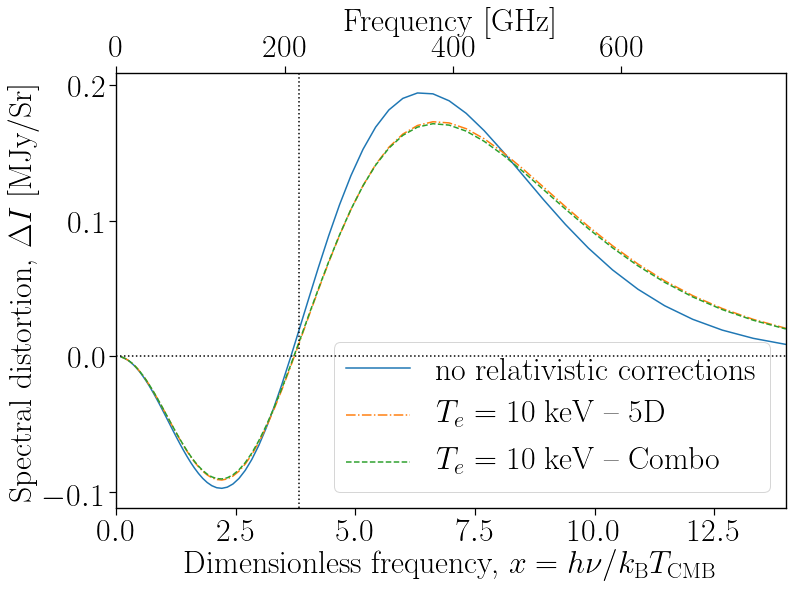

In [6]:
# A fully labelled graph to demonstrate what these later graphs will be showing.
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.plot(params.nucmb, np.zeros(params.gridpoints),'k',alpha=0)  #Twinning the nu values to the x values
ax2.axhline(y=0,c='k',ls=':')
ax2.axvline(x=217,c='k',ls=':')  # A vertical line to show the null of the non-relativistic SZ signal
ax1.plot(params.xcmb, nonRel*0.01/params.calc_The, label='no relativistic corrections')  
    # Here we set an overall compton parameter of y = 0.0001 
    # (i.e., we rescale since y = Dtau The, & Dtau = 0.01)
ax1.plot(params.xcmb, Full5D*0.01/params.calc_The, '-.', label='$T_e=10$ keV -- 5D')
ax1.plot(params.xcmb, combo*0.01/params.calc_The, '--', label='$T_e=10$ keV -- Combo')

ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.set_xlabel(r'Dimensionless frequency, $x= h\nu/k_{\rm B}T_{\rm CMB}$')
ax2.set_xlabel('Frequency [GHz]')
ax1.set_ylabel('Spectral distortion, $\Delta I$ [MJy/Sr]')

ax1.set_xlim(0,params.xcmb[-1])
ax2.set_xlim(0,params.nucmb[-1])
#ax1.set_ylim(-0.14,0.21)
ax1.legend()

for axs in [ax1,ax2]:
    for axis in ['top','bottom','left','right']:
        axs.spines[axis].set_linewidth(1.2)
    axs.tick_params(which='both', width=1.2)
    axs.tick_params(which='major', length=7)
    axs.tick_params(which='minor', length=4)

In [7]:
#The functions for calculating the SZ signal, using the parameters class.
params.runmode = "all"     # We will discuss this setting more later in this document.

# Note: This is disproportionately slow compared to normal running, because we are calculating 5D and 3D and thus 
# doing a lot of integration that would normally not be relevant
nonRel = SZ.compute_non_relativistic(params)
    # The signal with no relativistic corrections.
    # Note setting Te = 0 in general will return a result of 0, since it is being wrapped into y.
    # So this is the form that should be used.
comp5d = SZ.compute_5d(params)
    # The signal by computing all 5 integrals numerically. This method is slow.
comp3d = SZ.compute_3d(params)
    # The signal by precomputing two of the integrals analytically, under an assumption of low values for betac.
asym = SZ.compute_asymptotic(params, CMBframe=False)
    # An asymptotic expansion around Te. This setting is best for Te < 2 keV. It will throw an error for Te > 20 keV.
    # CMBframe exists for asym, CNSN, CNSNopt and combo.
    # It defaults to False, i.e., the signal is calculated in the observer frame (as is true for the other methods).
    # However, if set to True it will calculate the signal in the CMB frame instead.
CNSN = SZ.compute_CNSN(params)
    # A pivot based interpolation scheme described in Chluba et al. 2012.
    # This method will only calculate for 2 keV < Te < 75 keV. 
CNSNopt = SZ.compute_CNSN_opt(params)
    # A slightly more involved form of the previous scheme, summarised in Chluba et al. 2013.
    # The precision of this method depends on setting for kmax and accuracy level.
    # More details can be found in the documentatioon.
combo = SZ.compute_combo(params)
    # This setting will automatically calculate using the asymptotic mode for Te < 2 keV and CNSN above this.
precise = SZ.compute_precise(params)
    # This is the combo method, but above 75 keV it will default to the 3d method.

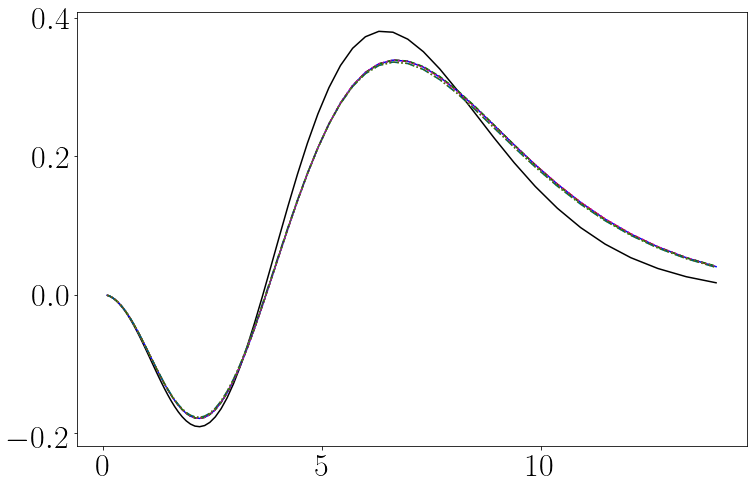

In [8]:
fig = plt.figure(figsize=(12,8))

plt.plot(params.xcmb, nonRel, 'k')
plt.plot(params.xcmb, comp5d, 'b')
plt.plot(params.xcmb, comp3d, 'r--')
plt.plot(params.xcmb, asym, 'g--')
plt.plot(params.xcmb, CNSN, 'c-.')
plt.plot(params.xcmb, CNSNopt, 'm:')
plt.plot(params.xcmb, combo, 'y:')
plt.plot(params.xcmb, precise, 'k-.', alpha=0.5)
# With these settings all these methods give pretty much identical results.
# However, in general this isn't true. See ___ for more information.
# We recommend in general combo or precise (if using very high temperatures), which should be sufficient in general.

In [9]:
# An explanation of the various run modes and what they do.
params.runmode = "full"       
mode_full = SZ.compute_5d(params)  # Note: This line is almost all of the run time of this cell.
    # This mode is only relevant for the 5d case, where we use the exponential for betac instead of an expansion.
params.runmode = "all"
mode_all = SZ.compute_combo(params)
    # All terms in the expansion up to betac^2.
params.runmode = "monopole"
mode_monopole = SZ.compute_combo(params)
    # Only the scattering of the monopole without any kinematic correction.
params.runmode = "dipole"
mode_dipole = SZ.compute_combo(params)
    # The first order kinematic correction, which causes a dipole term (i.e., O(betac muc)).
params.runmode = "quadrupole"
mode_quadrupole = SZ.compute_combo(params)
    # The second order kinematic correction -- where it causes a quadrupole term (i.e., O(betac^2 muc^2)).
params.runmode = "monopole_corr"
mode_monopole_corr = SZ.compute_combo(params)
    # The second order kinematic correction ot the monopole (i.e., O(betac^2)).
params.runmode = "kin"
mode_kin = SZ.compute_combo(params)
    # The combination of dipole, quadrupole and monopole_corr terms.
    # i.e., the combination of kinetic corrections up to order betac^2.

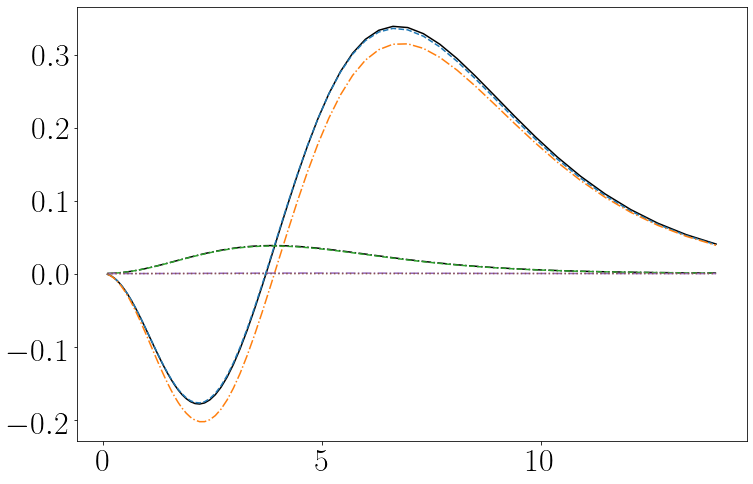

In [10]:
fig = plt.figure(figsize=(12,8))

plt.plot(params.xcmb, mode_full, 'k', label='full')
plt.plot(params.xcmb, mode_all, 'C0--', label='all')
plt.plot(params.xcmb, mode_kin, 'k-.', label='kin')
plt.plot(params.xcmb, mode_monopole, 'C1-.', label='monopole')
plt.plot(params.xcmb, mode_dipole, 'C2--', label='dipole')
plt.plot(params.xcmb, mode_quadrupole, 'C4-.', label='quadrupole')
plt.plot(params.xcmb, mode_monopole_corr, 'C5:', label='monopole\_corr')
#plt.legend()

Text(0, 0.5, '$\\Delta T/T_{\\rm CMB}$')

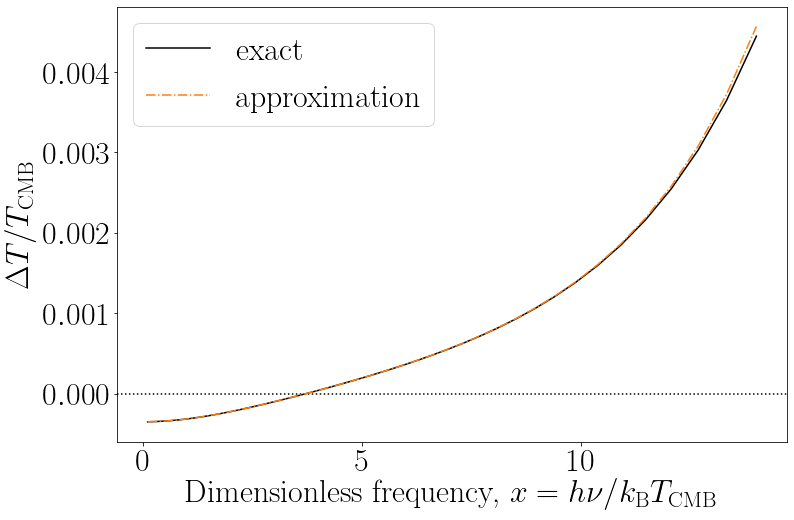

In [11]:
# Converting the output to DT/T
params.runmode = "all"
dn = SZ.compute_combo(params, DI=False)

dToT = SZ.convert_signal_DT(params.xcmb, dn)
    # This converts the Dn signal to DT/TCMB i.e., (the effective change in CMB temperature)/(CMB temperature) at a 
    # given frequency. This function inverts the boltzmann distribution to calculate the conversion accurately.
dToTapprox = SZ.convert_signal_DT_approx(params.xcmb, dn)
    # This does the same, except this function uses a conventional approximation from the first derivative 
    # of the boltzmann distribution. This gets less accurate as you go to higher frequencies.
    
fig = plt.figure(figsize=(12,8))
plt.axhline(y=0, c='k', ls=':')
plt.plot(params.xcmb, dToT, 'k', label='exact')
plt.plot(params.xcmb, dToTapprox, 'C1-.', label='approximation')
plt.legend()
plt.xlabel(r'Dimensionless frequency, $x= h\nu/k_{\rm B}T_{\rm CMB}$')
plt.ylabel(r'$\Delta T/T_{\rm CMB}$')

In [12]:
# A method to find the null crossing point for any given parameter set
SZ.compute_null(params)

3.737278314305245

In [13]:
# Calculating the signal using moments to account for variations of temperature and velocity within the line of sight.
# Described in detail in Chluba et al. 2013. i.e., the means method.
params.means_omega = 0.8       # The temperature dispersion term.
params.means_sigma = 0.05      # The velocity-temperature cross term.
params.means_kappa = 0.0       # The velocity (in the direction of the observer) dispersion term.

params.runmode = "all"
means = SZ.compute_means(params, yw=False)
    # The second term here determines whether the weighting used in determining these values is Dtau or y-weighted.
    # See Lee et al. 2020 for more details. Here we are using tau weighted values.

# There is also a method for setting these to higher orders for omega and sigma
params.means_assign_omegas(0.16, 0.0, 0.05)   # Setting the temperature dispersion to the third moment in temperature.
params.means_assign_sigmas(0.0, 0.0, 0.0)     # Setting the temperature-velocity terms to third order.

means_ex = SZ.compute_means_ex(params, yw=False)

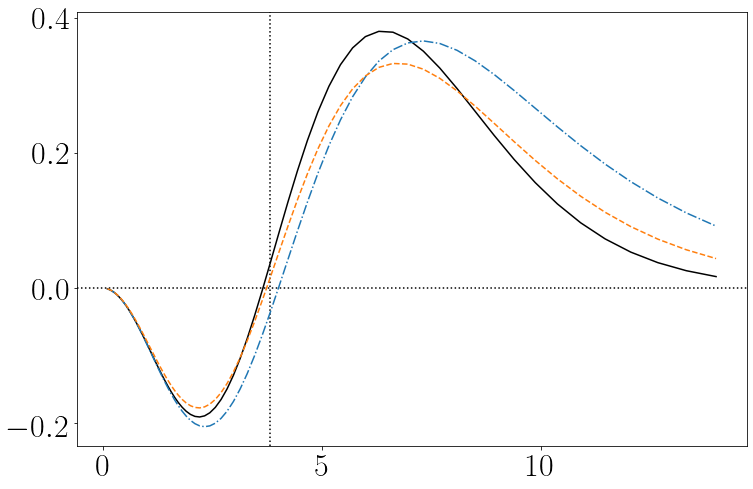

In [14]:
fig = plt.figure(figsize=(12,8))

plt.axhline(y=0, c='k', ls=':')
plt.axvline(x=3.8204, c='k', ls=':')

plt.plot(params.xcmb, SZ.compute_non_relativistic(params), 'k')
plt.plot(params.xcmb, means, '-.', label='full')
plt.plot(params.xcmb, means_ex, '--', label='all')

## Part 2: Avoiding the parameters class

How to access the functions without using the parameters class. In general this might lead to a little less flexibility and significantly less brevity to calculations. However, in certain circumstances, it may be more convenient.

In [15]:
x_array = np.logspace(np.log10(0.1),np.log10(20),100)
The = 5/510.999 # Converting 5 keV to dimensionless units. m_e = 510.999

nonRel = SZ.Nonrelativistic.compute_from_variables(x_array, The, 0.01, 0.5, "all")
comp5D = SZ.Integral5D.compute_from_variables(x_array, The, 0.01, 0.5, 1.0e-4, "monopole")
comp3D = SZ.Integral3D.compute_from_variables(x_array, The, 0.01, -0.5, 1.0e-4, "all")
asym = SZ.Asymptotic.compute_from_variables(x_array, The/2.0, 0.01, 0.05, 8, 2, "all", CMBframe=True)
    # For these from variable calculations, CMBframe defaults to true.
    # i.e., the calculation is done in the CMB frame. 
CNSN = SZ.CNSN_basis.compute_from_variables(x_array, The, 0.01, 0.05, 8, 2, "all")

In [16]:
x_array = np.logspace(np.log10(0.1),np.log10(20),100)
The = 5/510.999 # Converting 5 keV to dimensionless units. m_e = 510.999

print(SZ.CNSN_basis_opt.find_optimal_kmax(2, The*2))
    #This function gives the optimal kmax, given an accuracy level and a maximum temperature to be probed.
CNSNopt = SZ.CNSN_basis_opt.compute_from_variables(x_array, The*2, 0.01, 0.05, 5, 2, 2, "all", CMBframe=False)

5


In [17]:
means = SZ.compute_means_from_variables(x_array, The, 0.01, 0.5, "all", 0.0, 0.05, 0, yw=False)
means_ex = SZ.compute_means_ex_from_variables(x_array, The, 0.01, 0.5, "all", 
                                              np.array([0.16, 0, 0.05]), np.array([0, 0, 0]), 0, yw=False)

In [18]:
combo = SZ.compute_combo_from_variables(x_array, The*1.5, 0.01, 0.5, 8, 2, "all")

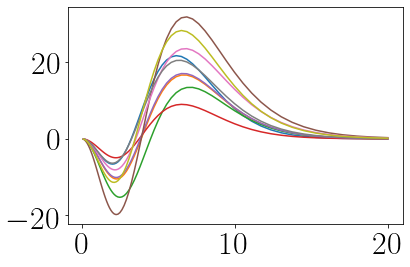

In [19]:
plt.plot(x_array, nonRel)
plt.plot(x_array, comp5D)
plt.plot(x_array, comp3D)
plt.plot(x_array, asym)
plt.plot(x_array, CNSN)
plt.plot(x_array, CNSNopt)
plt.plot(x_array, means)
plt.plot(x_array, means_ex)
plt.plot(x_array, combo)
# Note, these aren't multiplied by tau 

## Part 3: The parameters class

A more detailed look at the parameters class, all the settings within it, what they do and how to modify them.

In [20]:
params2 = SZ.parameters()

In [21]:
params2.copy_parameters(params)
params2.set_parameters_from_file("../runfiles/parameters.dat")

In [22]:
params2.set_x_array(0.1,14,100)    # Set the dimensionless frequencies x.
    # The array is logarithmically spaced from xmin (0.1) to xmax (14) with 100 points.
params2.set_x_from_nu(10,850,100)  # Setts the dimensionless frequencies, from the frequencies in GHz.
    # The array is logarithmically spaced from nu_min (10) to nu_max (850) with 100 points.

# These methods set the following parameters. xmin and xmax are the min and max values of x.
# Gridpoints is the number of points in the x_array.
# xcmb and nucmb are the arrays of x and nu that we calculate over respectively.
# nu is the frequency and x the dimensionless frequency.
#(params2.xmin, params2.xmax, params2.gridpoints, params2.xcmb, params2.nucmb)

In [23]:
params2.betao = 0.0                # Peculiar velocity of observer with respect to CMB frame (betac = v/c)
params2.muo = 0.0                  # Cosine of line-of-sight to the observers velocity. Angle measured in the observer frame
params2.betac = 0.01               # Peculiar velocity of cluster with respect to CMB frame (betao = v/c)
params2.muc = 1.0                  # Cosine of cluster velocity to the line-of-sight in the CMB rest frame
params2.Te = 10                    # Electron temperature in keV
params2.Dtau = 0.01                # The optical depth (must be > 0)

# These set some calculated values which cannot be directly modified, but are changed when these change.
# In particular, The, the dimensionless temperature;
# gammao and gammac, the dimensionless energy = 1/Sqrt(1-beta^2) for betao and betac;
# mucc, muc transformed into the cluster frame;
# betac_para = betac muc, the parallel component of betac
# betac2_perp = (betac**2)*(1-muc**2), the square of the perpendicular component of betac
# CNSN_Dtau, Dtau but using the nozawa conventions. More details can be found in ___.
# This can be used to renormalise the signal to that supposing the nozawa convention.
(params2.calc_The, params2.calc_gammao, params2.calc_gammac, params2.calc_mucc, params2.calc_betac_para, 
 params2.calc_betac2_perp, params2.calc_CNSN_Dtau)

(0.01956951336745513,
 1.0,
 1.0000500037503126,
 1.0,
 0.01,
 0.0,
 0.009900495037128094)

In [24]:
# These parameters are used for the CNSN and Asymptotic methods
params2.T_order                    # Order of expansion with respect to Te. Used only for CNSN and aymptotic methods.
params2.beta_order                 # Order of expansion with respect to beta. Used only for CNSN and aymptotic methods.

2

In [25]:
params2.relative_accuracy          # This is used in the 3D and 5D methods to determine the accuracy of the integrals 

0.0001

In [26]:
# These parameters are all used for the CNSNopt method. More details can be found in Chluba et al. 2013.
params2.kmax
params2.accuracy_level
params2.Te_max

30.0

In [27]:
# These parameters are used for the means and means_ex methods.
params2.means_omega                # The temperature dispersion term.
params2.means_sigma                # The velocity-temperature cross term.
params2.means_kappa                # The line-of-sight velocity dispersion term.

# For the means_ex method, we can also set omegas and sigmas for higher orders in the expansion
params2.means_assign_omegas(0,0,0) # Setting the temperature dispersion to the third moment in temperature.
params2.means_assign_sigmas(0,0,0) # Setting the temperature-velocity terms to third order.

(params2.means_omegas, params2.means_sigmas)

([0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [28]:
# Other miscellaneous parameters
params2.rare_TCMB                  # We can set the CMB temperature arbitrarily
params2.runmode                    # The runmode has been discussed before in depth in section 1.

(params2.rare_Dn_DI_conversion, params2.rare_x_nu_conversion)

(270.2124844510569, 56.800691527967444)

## Part 4: Miscellaneous other functionalities

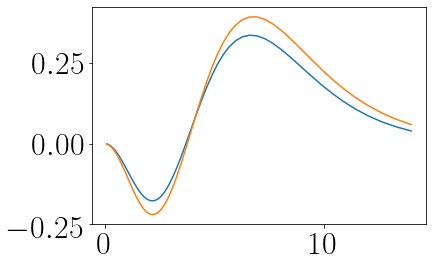

In [29]:
# This calculates the combined signal of two overlaying thermal distributions of electrons
TwoTemp = SZ.compute_two_temperatures(0.2,1.2,params)
    # The 0.2 is the fraction of the optical depth at the second temperature, i.e., DTau1/Dtau_total.
    # The 1.2 is the proportional difference between the temperatures. i.e., (T1-T0)/T0

plt.plot(params.xcmb, SZ.compute_combo(params))
plt.plot(params.xcmb, TwoTemp)

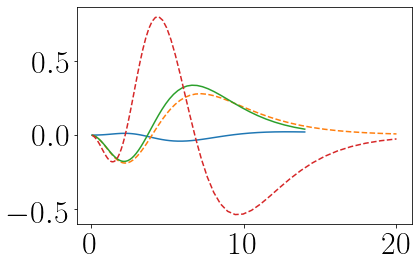

In [30]:
# This computes various derivatives of the SZ signal. These are all calculated in the CMB frame

# These functions calculate the derivatives with respect to The, betac_para and betac2_perp respectively.
# where betac_para is beta in the direction of the cluster movement i.e., betac*muc
# and betac2_perp is beta perpendicular to this. i.e., betac^2*(1-muc^2).
# The three integers >=0 (params, i,j,k) return 1/(i!j!k!)*(d^i/dThe^i)(d^j/dbetac_para^j)(d^k/dbetac2_perp^k)(signal).
# i<=4, j<=2 and k<=1 (where i=j=k=0 returns the combo signal itself)
dthe = SZ.Dcompute_combo_CMB(params, 2,0,0)
dthe_var = SZ.Dcompute_from_variables(x_array, 1,0,0, 10./510.999, 0.0, 0.0)

# These functions compute the x derivatives. i.e., (params, n) where n is d^n/dx^n (signal).
# This works for n <= 4 (where n=0 returns the combo signal itself)
dx = SZ.Dcompute_combo_for_x(params, 0)
dx_var = SZ.Dcompute_for_x_from_variables(x_array, 1, 10./510.999, 0.0, 0.0) 

plt.plot(params.xcmb, dthe)
plt.plot(x_array, 0.01*dthe_var, '--')
plt.plot(params.xcmb, dx)
plt.plot(x_array, 0.01*dx_var, '--')

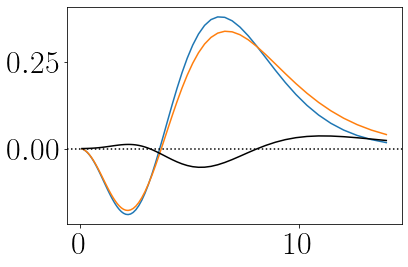

In [31]:
# The function to calculate the relativistic corrections. This calculates the differences between the non-relativistic
# method and the combo method, in the CMB frame.
rel_corr = SZ.compute_relativistic_corrections(params)

plt.plot(params.xcmb, SZ.compute_non_relativistic(params))
plt.plot(params.xcmb, SZ.compute_combo(params, CMBframe=True))
plt.plot(params.xcmb, rel_corr, 'k')
plt.axhline(y=0, c='k',ls=':')

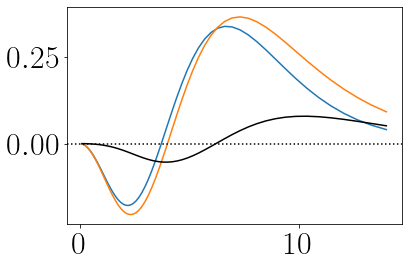

In [32]:
# Finally we have the temperature dispersion function. This calculates the difference between the means signal given
# the omega, sigma and kappa values that have been set, and the signal without these variables, all calculated in the
# CMB frame.
temp_disp = SZ.compute_temperature_dispersion(params)

plt.plot(params.xcmb, SZ.compute_combo(params, CMBframe=True))
plt.plot(params.xcmb, SZ.compute_means(params, False))
plt.plot(params.xcmb, temp_disp, 'k')
plt.axhline(y=0, c='k',ls=':')